In [3]:
from lib.data.cityscapes import CityscapesDataset

ds = CityscapesDataset(
    root="data/cityscapes",
    split="train",
    train_size=(1024, 1024),
    val_size=(1024, 2048),
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    ignore_index=255,
    bbox_format="pascal_voc",
    logger=None,
)

aachen_000007_000019_leftImg8bit.png


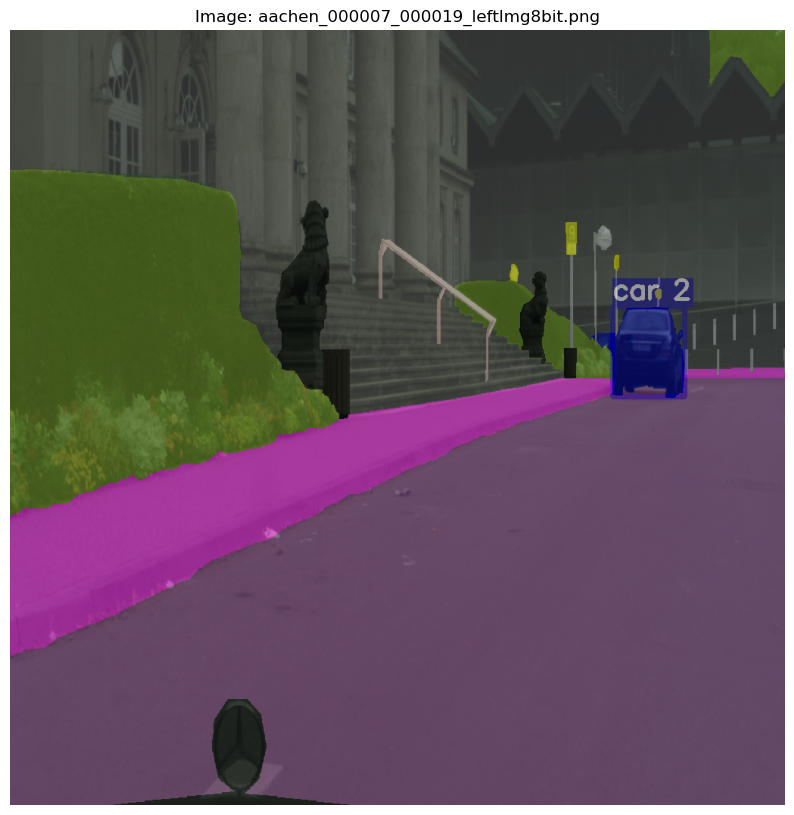

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def process_image(image, ds):
    image = (image.transpose(1, 2, 0) * np.array(ds.std) + np.array(ds.mean)) * 255
    image = image.astype(np.uint8)
    return image


def process_mask(seg_mask, ds):
    colored_mask = np.zeros((*image.shape[:2], 3), dtype=np.uint8)
    for id, color in enumerate(ds.COLOR_PALETTE):
        colored_mask[seg_mask == id] = ds.COLOR_PALETTE[color]
    return colored_mask


def process_bboxes(image, bboxes, labels, ds):
    for idx, bbox in enumerate(bboxes):
        bbox = bbox.numpy().astype(np.int32)
        label = (
            ds.LOCALIZATION_CLASSES[labels[idx].item()] + " " + str(labels[idx].item())
        )
        color = ds.COLOR_PALETTE[11 + labels[idx].item()]

        image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 5)

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
        image = cv2.rectangle(
            image, (bbox[0], bbox[1] - h - 10), (bbox[0] + w, bbox[1]), color, -1
        )
        image = cv2.putText(
            image,
            label,
            (bbox[0], bbox[1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.2,
            [255, 255, 255],
            3,
        )
    return image


image, bboxes, labels, mask, heatmap, infos = ds[7]
print(infos["name"])
image = process_image(image.numpy(), ds)
seg_mask = mask.numpy().astype(np.uint8)
colored_mask = process_mask(seg_mask, ds)
image = process_bboxes(image.copy(), bboxes, labels, ds)

plt.figure(figsize=(10, 20))
plt.title(f"Image: {infos['name']}")
plt.imshow(image)
plt.imshow(colored_mask, alpha=0.55)
plt.axis("off")
plt.show()

In [3]:
# dict = {
#     0: 1,
#     1: 2,
#     2: 7,
#     3: 0,
#     4: 6,
#     5: 3,
#     6: 4,
#     7: 5,
# }

# with open("data/cityscapes/train.txt", "r") as fr:
#     lines = fr.read().splitlines()

# for line in lines:
#     with open("data/cityscapes/" + line.split()[-1], "r") as fr:
#         bboxes = fr.read().splitlines()

#     # print(bboxes)

#     with open("data/cityscapes/" + line.split()[-1], "w") as fw:
#         for bbox in bboxes:
#             fw.write(f"{dict[int(bbox.split()[0])]} {bbox.split()[1]} {bbox.split()[2]} {bbox.split()[3]} {bbox.split()[4]}\n")

#     # print(f"{dict[int(bboxes[0].split()[0])]} {bboxes[0].split()[1]} {bboxes[0].split()[2]} {bboxes[0].split()[3]} {bboxes[0].split()[4]}\n")


#     # break

In [2]:
# with open("data/cityscapes/val.txt", "r") as fr:
#     lines = fr.read().splitlines()

# with open("data/cityscapes/val_new.txt", "w") as fw_main:
#     for line in lines:
#         img_path, mask_path, bbox_path = line.split()

#         with open("data/cityscapes/" + bbox_path, "r") as fr:
#             bboxes = fr.read().splitlines()

#         valid = []

#         for bbox in bboxes:
#             cls_id, x1, y1, x2, y2 = list(map(int, bbox.split()))
#             width = x2 - x1
#             height = y2 - y1
#             if width > 10 and height > 10:
#                 valid.append((cls_id, x1, y1, x2, y2))

#             # break

#         if not valid:
#             continue

#         with open("data/cityscapes/" + bbox_path, "w") as fw:
#             for cls_id, x1, y1, x2, y2 in valid:
#                 fw.write(f"{cls_id} {x1} {x2} {y1} {y2}\n")

#         fw_main.write(f"{img_path} {mask_path} {bbox_path}\n")

#         # break